In [153]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


In [132]:
df = pd.read_csv('../train.csv')
df['squared_return'] = df['forward_returns'] ** 2
y = df['squared_return'] - df['squared_return'].shift(1)
df['lagged_return'] = df['forward_returns'].shift(1)
df['lagged_risk_free_rate'] = df['risk_free_rate'].shift(1)
df['lagged_risk_free_rate_change'] = df['lagged_risk_free_rate'] - df['lagged_risk_free_rate'].shift(1)
df['rolling_var'] = df['squared_return'].shift(1).rolling(window=4).mean()
df['prev_squared_return'] = df['squared_return'].shift(1)
X = df.drop(columns=['date_id', 'forward_returns', 'squared_return', 'market_forward_excess_returns', 'D1'])

In [133]:
def hygiene(X, pct = 0.2):
    out = X.copy()
    drop_cols = []
    for col in out.columns:
        if out[col].isna().sum()/len(out) > pct:
            drop_cols.append(col)
    out = out.drop(columns=drop_cols)
    return out, drop_cols

In [134]:
X_cleaned, dropped_columns = hygiene(X, pct=0.2)

In [135]:
X_cleaned.dropna(inplace=True)

In [136]:
X_cleaned = X_cleaned - X_cleaned.mean()
X_cleaned = X_cleaned / X_cleaned.std()

In [137]:
X_train = X_cleaned[:5000]
X_val = X_cleaned[5000:6000]
X_test = X_cleaned[6000:]
y_train = y[X_train.index]
y_val = y[X_val.index]
y_test = df['squared_return'][X_test.index]


In [138]:
from scipy.stats import pearsonr

In [139]:
def feature_selection(X, y, k = 30):
    y_corr = {}
    for col in X.columns:
        rho, p = pearsonr(X[col], y)
        y_corr[col] = {'rho': rho, 'p_value': p}
    y_corr_df = pd.DataFrame(y_corr).T
    y_corr_df = y_corr_df.sort_values(by='p_value', ascending=True)
    selected_features = y_corr_df.index[:k].tolist()
    return selected_features, y_corr_df

In [140]:
ridge_model = Ridge(alpha=1.0)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42, max_features=0.7)


In [141]:
ridge_features, y_corr_df = feature_selection(X_cleaned, y.loc[X_cleaned.index], k=5)

In [142]:
y_corr_df

,rho,p_value
prev_squared_return,-0.607730,0.000000e+00
rolling_var,-0.209262,4.007557e-72
lagged_return,-0.048076,4.450332e-05
P7,-0.040925,5.110848e-04
V13,-0.024909,3.448018e-02
...,...,...
V8,0.000075,9.949317e-01
V4,-0.000047,9.967913e-01
M18,0.000046,9.969021e-01
M16,0.000034,9.976695e-01


In [143]:
ridge_model.fit(X_train[ridge_features], y_train)

Ridge()

In [144]:
ridge_val = ridge_model.predict(X_val[ridge_features])

In [145]:
pearsonr(ridge_val, y_val)

PearsonRResult(statistic=np.float64(0.6936352463294727), pvalue=np.float64(2.3711032234874358e-144))

In [146]:
rf_model.fit(X_train, y_train)
rf_val = rf_model.predict(X_val)
pearsonr(rf_val, y_val)

PearsonRResult(statistic=np.float64(0.6513366474871689), pvalue=np.float64(8.883652711637971e-122))

In [155]:
lightgbm_model = LGBMRegressor(n_estimators=100, max_depth=6, random_state=42, learning_rate=0.03, verbose=-1)
lightgbm_model.fit(X_train, y_train)
lgbm_val = lightgbm_model.predict(X_val)

In [156]:
pearsonr(lgbm_val, y_val)

PearsonRResult(statistic=np.float64(0.6659966536352687), pvalue=np.float64(3.5099201978869856e-129))

In [147]:
import matplotlib.pyplot as plt


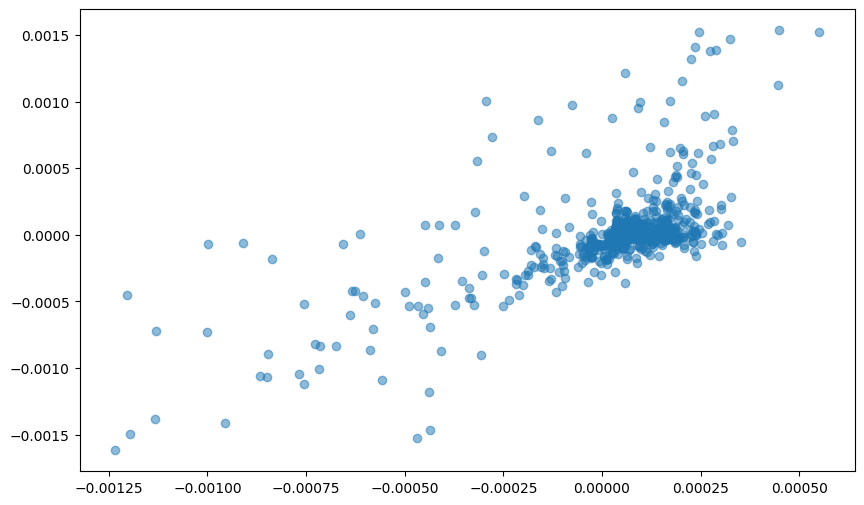

In [148]:
plt.figure(figsize=(10, 6))
plt.scatter(rf_val, y_val, alpha=0.5, label='Random Forest')
plt.show()

In [149]:
def var_prediction(X, rf_model):
    var_prev = X['prev_squared_return'] 
    var_change_pred = rf_model.predict(X)
    return var_prev + var_change_pred


In [150]:
pearsonr(var_prediction(X_test, rf_model), y_test)


PearsonRResult(statistic=np.float64(0.192746262370648), pvalue=np.float64(1.477969714618901e-11))

In [151]:
pearsonr(X_test['rolling_var'], y_test)

PearsonRResult(statistic=np.float64(0.31689618402300596), pvalue=np.float64(1.5433996095321045e-29))

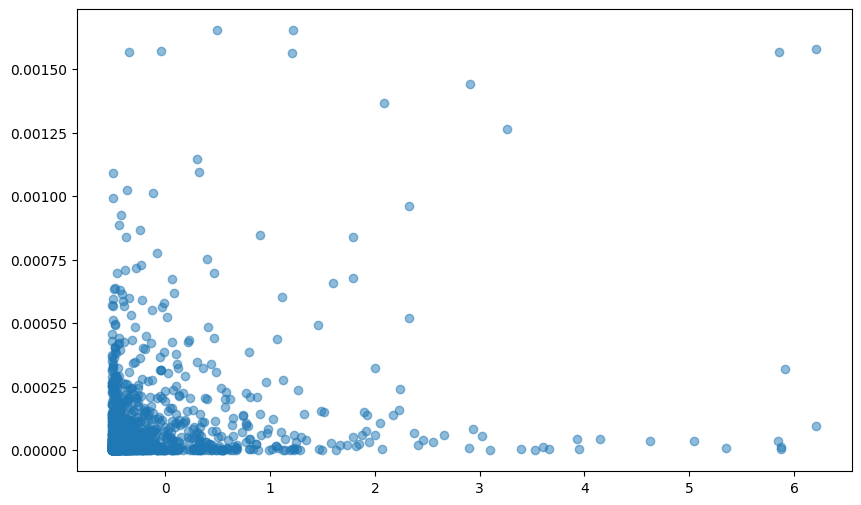

In [152]:
plt.figure(figsize=(10, 6))
plt.scatter(var_prediction(X_test, rf_model), y_test, alpha=0.5, label='Predicted vs Actual Variance')